In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from scipy import stats as st
from scipy.optimize import curve_fit



class FatigueData:
    def __init__(self, name, file, threshold, window):
        self.file = file
        self.name = name
        self.threshold = threshold
        self.window = window
        self.data = self.loadData()

     
    def loadData(self):
        data = pd.read_csv(self.file, skiprows=3, header=None)

        def interpolate(df, x, y, likelihood, threshold):
            for i in range(1, len(df)):
                if df.iloc[i, likelihood] < threshold:
                    df.iloc[i, x] = df.iloc[i-1, x]
                    df.iloc[i, y] = df.iloc[i-1, y]

        #interpolate

        for i in range(3,len(data.columns),3):
            likelihood = i + 2  
            x_col = i  
            y_col = i + 1  
            interpolate(data, x_col, y_col, likelihood, self.threshold)

            #moving average
        # for i in range(3, len(data.columns),3):
        #     x = data.columns[i]
        #     y = data.columns[i+1]
        #     data[x] = data[x].rolling(window=self.window, min_periods=1).mean()
        #     data[y] = data[y].rolling(window=self.window, min_periods=1).mean()        

        def calculate_angle(p3,p2, p1):
            #Calculate the angle at p2
            #Calculate the vectors
            v1 = np.array(p1) - np.array(p2)
            v2 = np.array(p3) - np.array(p2)
            #Calculate the angle
            angle = np.arccos(np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            z = p3[1] - p1[1]
            #Convert to degrees
            angle = np.degrees(angle)
            if z < 0:
                angle = 360 - angle
            return angle

        angle = []
        for i in range(len(data)):  #save angle for each posture for all frames
            forearm = (data.iloc[i][data.columns[15]], data.iloc[i][data.columns[16]])
            wrist = (data.iloc[i][data.columns[12]], data.iloc[i][data.columns[13]])
            mcp = (data.iloc[i][data.columns[9]], data.iloc[i][data.columns[10]])
            # pip = (data.iloc[i][data.columns[6]], data.iloc[i][data.columns[7]])
            # dip = (data.iloc[i][data.columns[3]], data.iloc[i][data.columns[4]])
            angle.append(calculate_angle(forearm, wrist, mcp))
        smoothed = uniform_filter1d(np.array(angle), size=self.window)
        return smoothed
    
    def plotAll(self,height=130, prominence=10, width=10, window=10, distance=10):

        self.peaks, _ = find_peaks(self.data, height=height, prominence=prominence, width=width, distance=distance)  
        self.valleys, _ = find_peaks(-self.data, height=-170, prominence=10, width=10)  
        
        # Plot the results
        plt.figure(figsize=(25, 5))
        plt.plot(self.data)
        plt.plot(self.peaks, self.data[self.peaks], "x", label='Peaks')
        plt.plot(self.valleys, self.data[self.valleys], "o", label='Valleys')
        # for peak in self.peaks:
        #     plt.axvline(x=peak-window, color='r', linestyle='--')
        #     plt.axvline(x=peak+window, color='b', linestyle='--')
        plt.title(f'{self.name} Fatigue Data')
        plt.xlabel('Frame')
        plt.ylabel('Angle')
        plt.legend()
        plt.show()

    def getAngleChange(self,window):
        angleChanges = []
        for i in range(len(self.peaks)):
            median = np.median(self.data[self.peaks[i]-window:self.peaks[i]+window])
            angleChanges.append(median) # - self.data[self.valleys[-restIdx]])
        self.angleChanges = angleChanges
        # plt.figure(figsize=(10, 6))
        # plt.scatter(np.arange(len(angleChanges)), angleChanges,label='Original Data', color = 'r',)
        # plt.xlabel("Stimulus Number")
        # plt.ylabel("Mean Change in Angle (Percent)")
        # plt.title(f'{self.name} Fatigue Data')
        # plt.legend()
        # plt.show()

    def testAngleChange(self):
        peak_valley_differences = []
        peak_index = 0
        valley_index = 0
        plt.plot(self.data)
        while peak_index < len(self.peaks) and valley_index < len(self.valleys):
            if self.valleys[valley_index] < self.peaks[peak_index]:
                if peak_index == 0 or (valley_index > 0 and self.valleys[valley_index] > self.peaks[peak_index - 1]):
                    difference = self.data[self.peaks[peak_index]] - self.data[self.valleys[valley_index]]
                    # print(self.peaks[peak_index], self.valleys[valley_index], difference)
                    plt.axvline(x=self.peaks[peak_index], color='r', linestyle='--')
                    plt.axvline(x=self.valleys[valley_index], color='g', linestyle='--')
                    peak_valley_differences.append(difference)
                    peak_index += 1
                valley_index += 1
            else:
                peak_index += 1

        self.angleChanges = peak_valley_differences
    
    def fitExponentialDecay(self):
        means  = np.array(self.angleChanges)
        mask = ~np.isnan(means)
        filtered_means = means[mask]
        filtered_indices = np.arange(len(means))[mask]
        # Perform curve fitting

        popt, _ = curve_fit(exponential_decay, filtered_indices, filtered_means, maxfev=10000)

        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.scatter(np.arange(len(means)), means,label='Original Data', color = 'r',)
        plt.plot(filtered_indices, exponential_decay(filtered_indices, *popt), label=f'{popt[0]:.2f} * exp^(-{popt[1]:.2f} * x) + {popt[2]:.2f}')
        plt.xlabel("Stimulus Number")
        plt.ylabel("Mean Change in Angle (Percent)")
        plt.legend()
        plt.show()
        
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

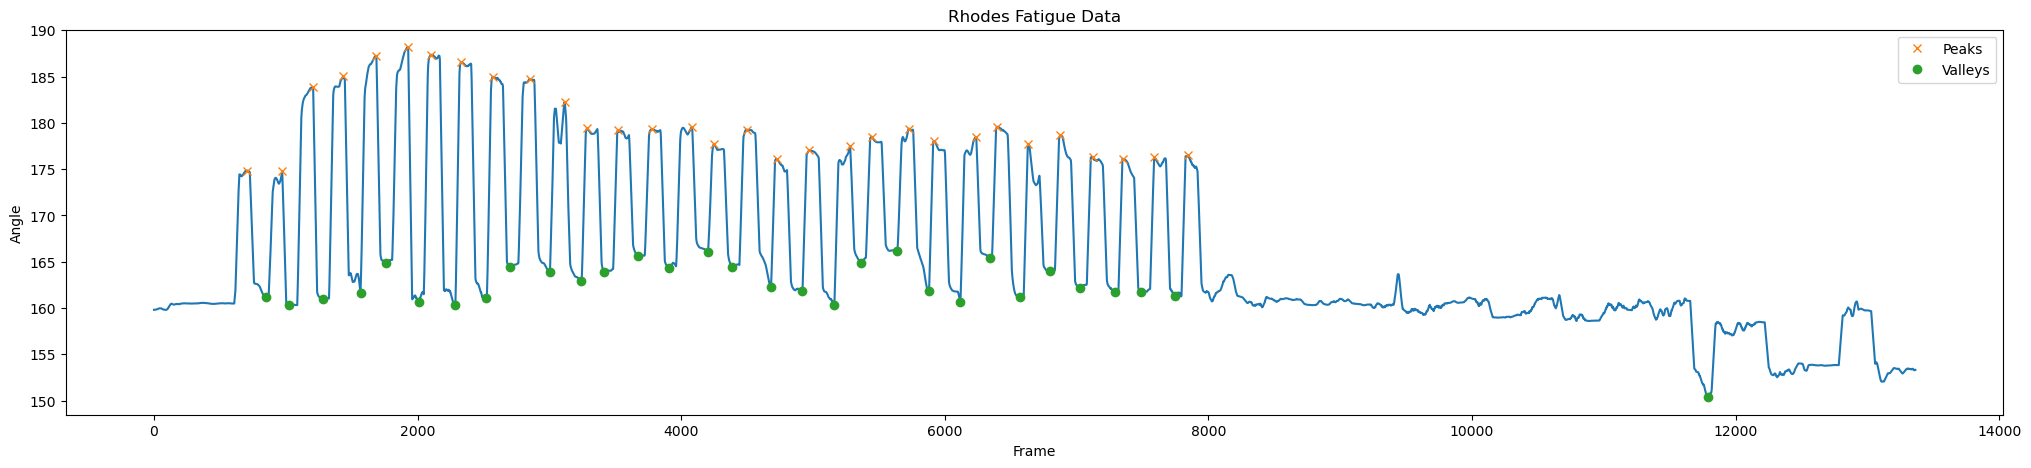

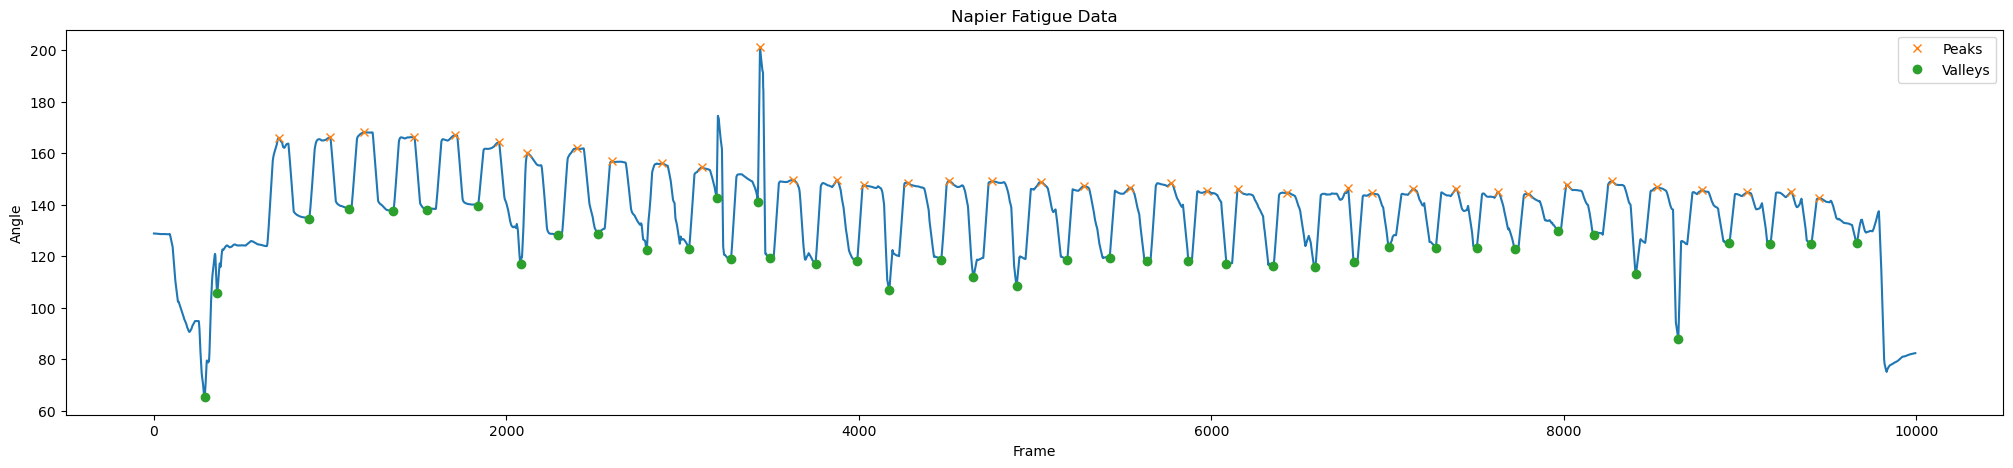

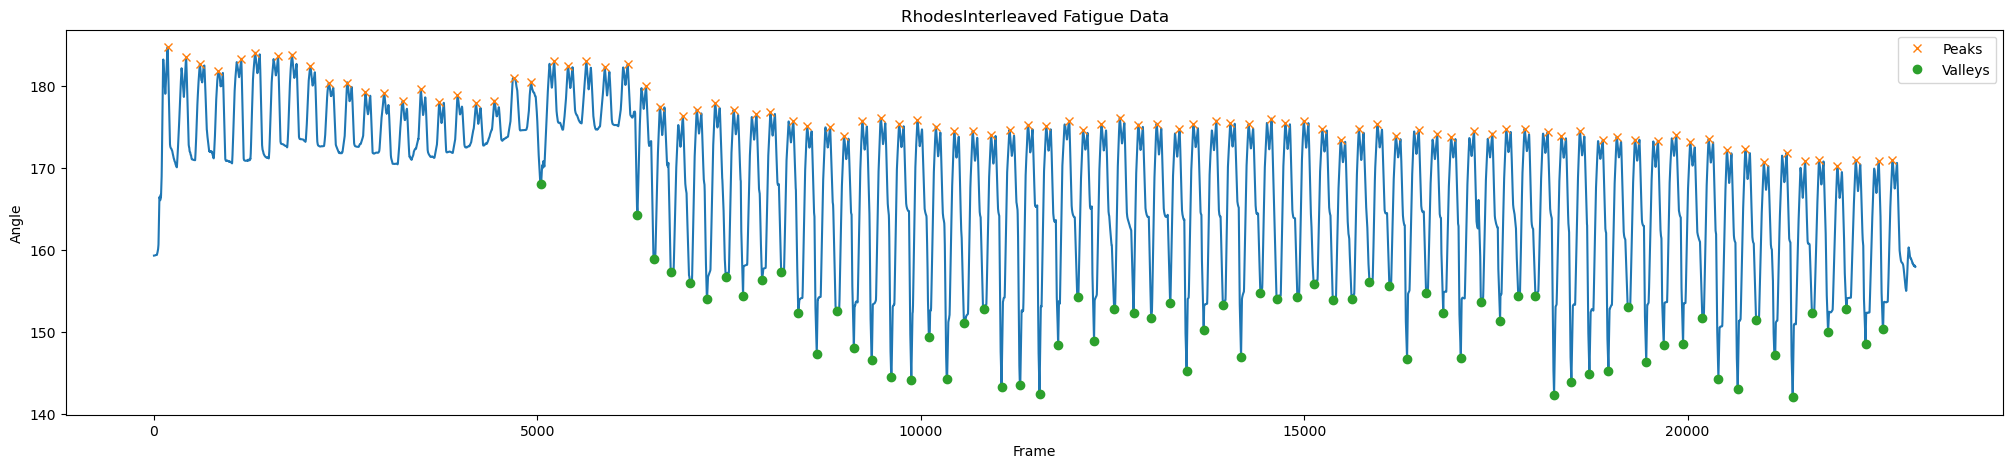

In [137]:
thresh = 0.5
window = 30
rhodes = FatigueData("Rhodes", "/home/jakejoseph/Desktop/Joseph_Code/SLEAPV3/rhodesfatigue.csv", thresh, window)
rhodes.plotAll(window=50, distance=5)
napier = FatigueData("Napier","/home/jakejoseph/Desktop/Joseph_Code/SLEAPV3/napierfatigue.csv", 0.5, 30)
napier.plotAll(window = 50, height=130, prominence=10, width=110, distance=5)
rhodesinterleaved = FatigueData("RhodesInterleaved","/home/jakejoseph/Desktop/Joseph_Code/SLEAPV3/rhodesinterleavedfatigue.csv", thresh, window)
rhodesinterleaved.plotAll(window = 50, height=130, prominence=4, width=20, distance=2)

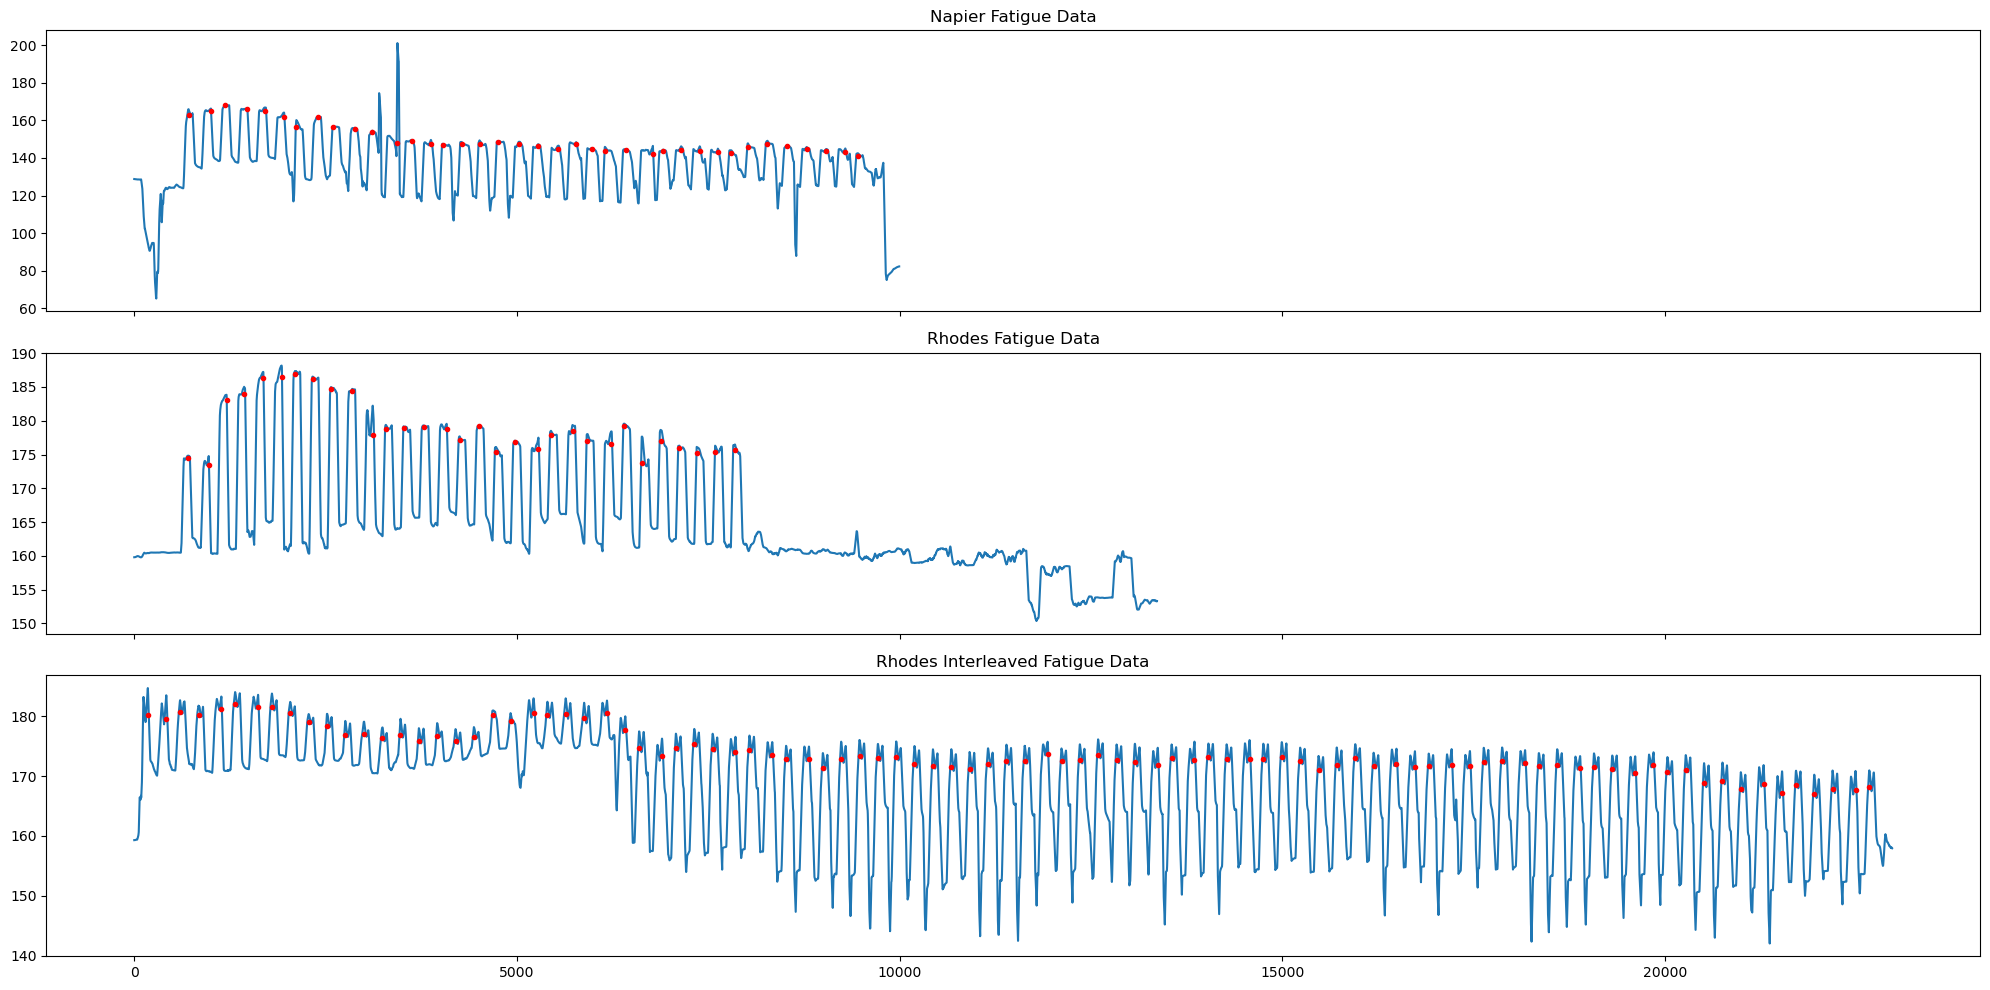

In [134]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)  # Add sharex=True

# Plot for napier
axs[0].plot(napier.data)
axs[0].plot(napier.peaks, napier.angleChanges, ".r", label='Peaks')
axs[0].set_title('Napier Fatigue Data')

# Plot for rhodes
axs[1].plot(rhodes.data)
axs[1].plot(rhodes.peaks, rhodes.angleChanges, ".r", label='Peaks')
axs[1].set_title('Rhodes Fatigue Data')

# Plot for rhodesinterleaved
axs[2].plot(rhodesinterleaved.data)
axs[2].plot(rhodesinterleaved.peaks, rhodesinterleaved.angleChanges, ".r", label='Peaks')
axs[2].set_title('Rhodes Interleaved Fatigue Data')

plt.tight_layout()
plt.show()

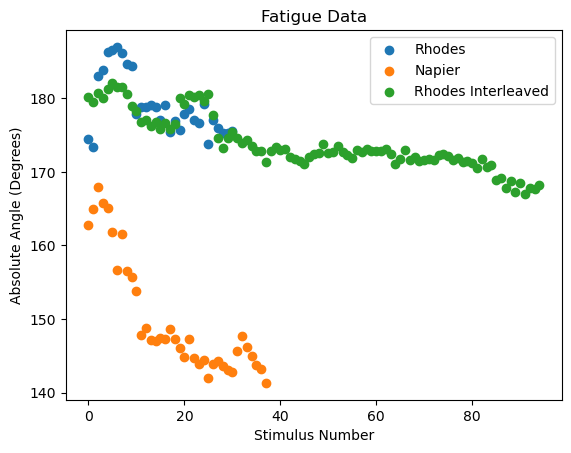

In [138]:
rhodes.getAngleChange(50)
napier.getAngleChange(50)
rhodesinterleaved.getAngleChange(50)

plt.figure()
plt.scatter(np.arange(len(rhodes.angleChanges)), rhodes.angleChanges, label='Rhodes')
plt.scatter(np.arange(len(napier.angleChanges)), napier.angleChanges, label='Napier')
plt.scatter(np.arange(len(rhodesinterleaved.angleChanges)), rhodesinterleaved.angleChanges, label='Rhodes Interleaved')
plt.xlabel("Stimulus Number")
plt.ylabel("Absolute Angle (Degrees)")
plt.title(f'Fatigue Data')
plt.legend()

/home/jakejoseph/anaconda3/envs/sleap/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in exp


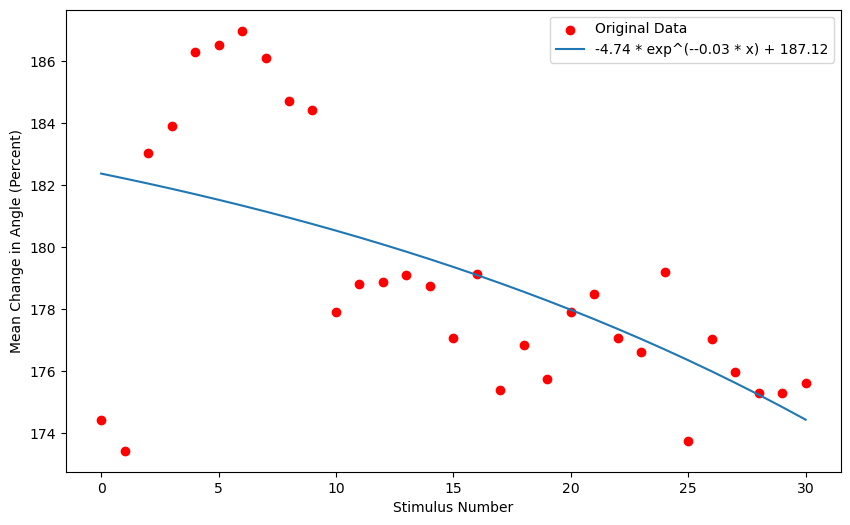

/home/jakejoseph/anaconda3/envs/sleap/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


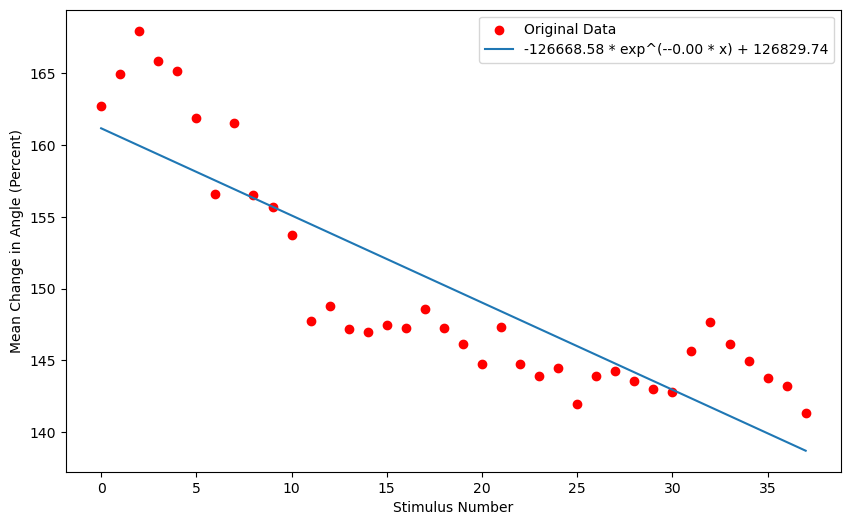

/home/jakejoseph/anaconda3/envs/sleap/lib/python3.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in multiply


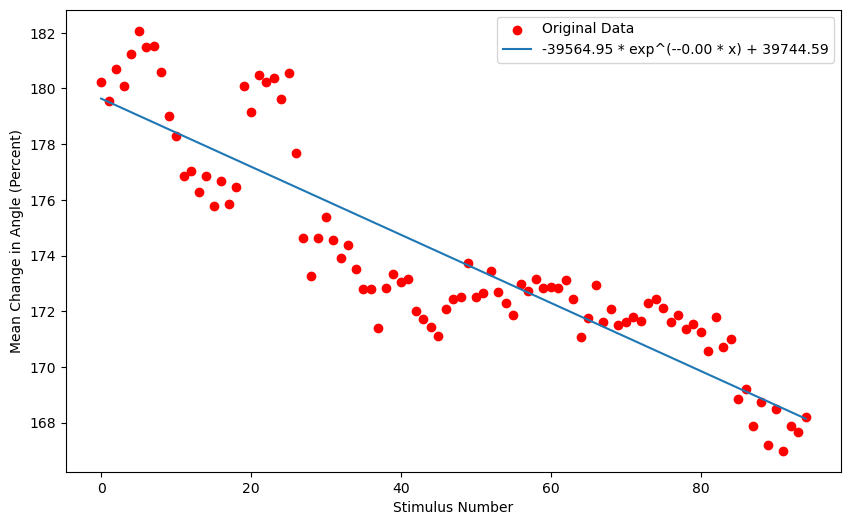

In [140]:
rhodes.fitExponentialDecay()
napier.fitExponentialDecay()
rhodesinterleaved.fitExponentialDecay()

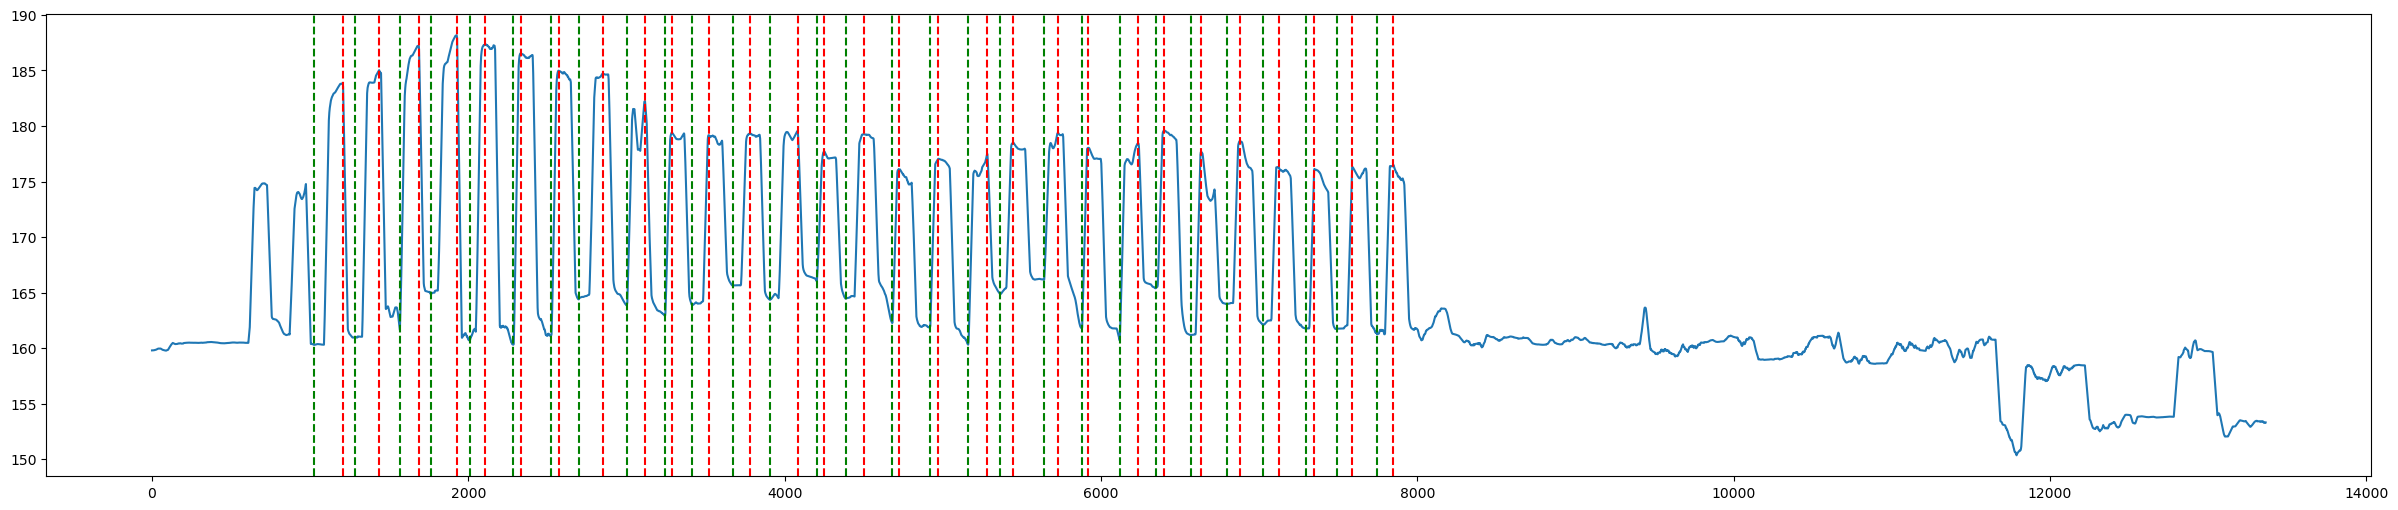

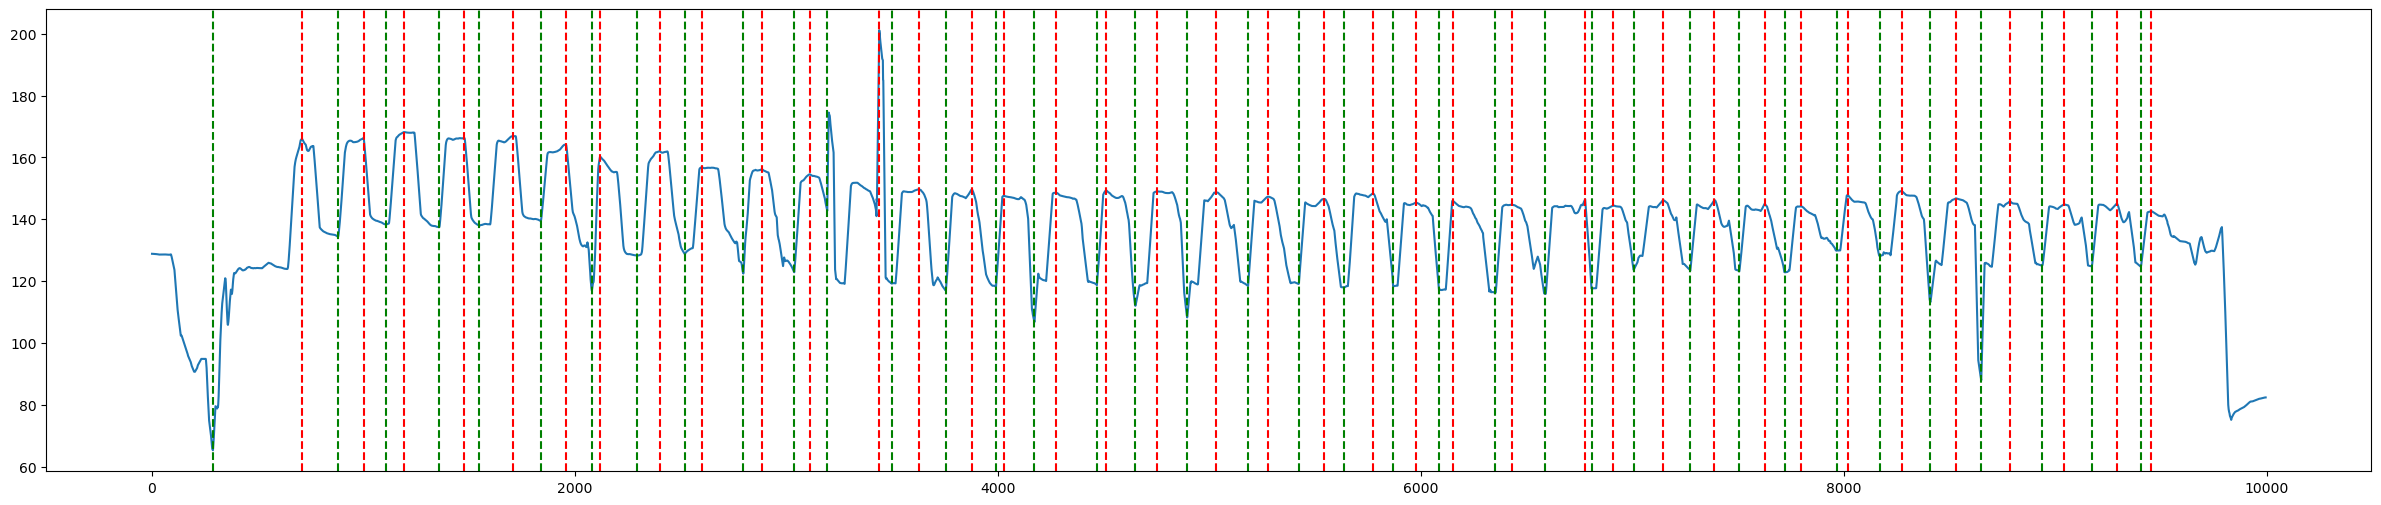

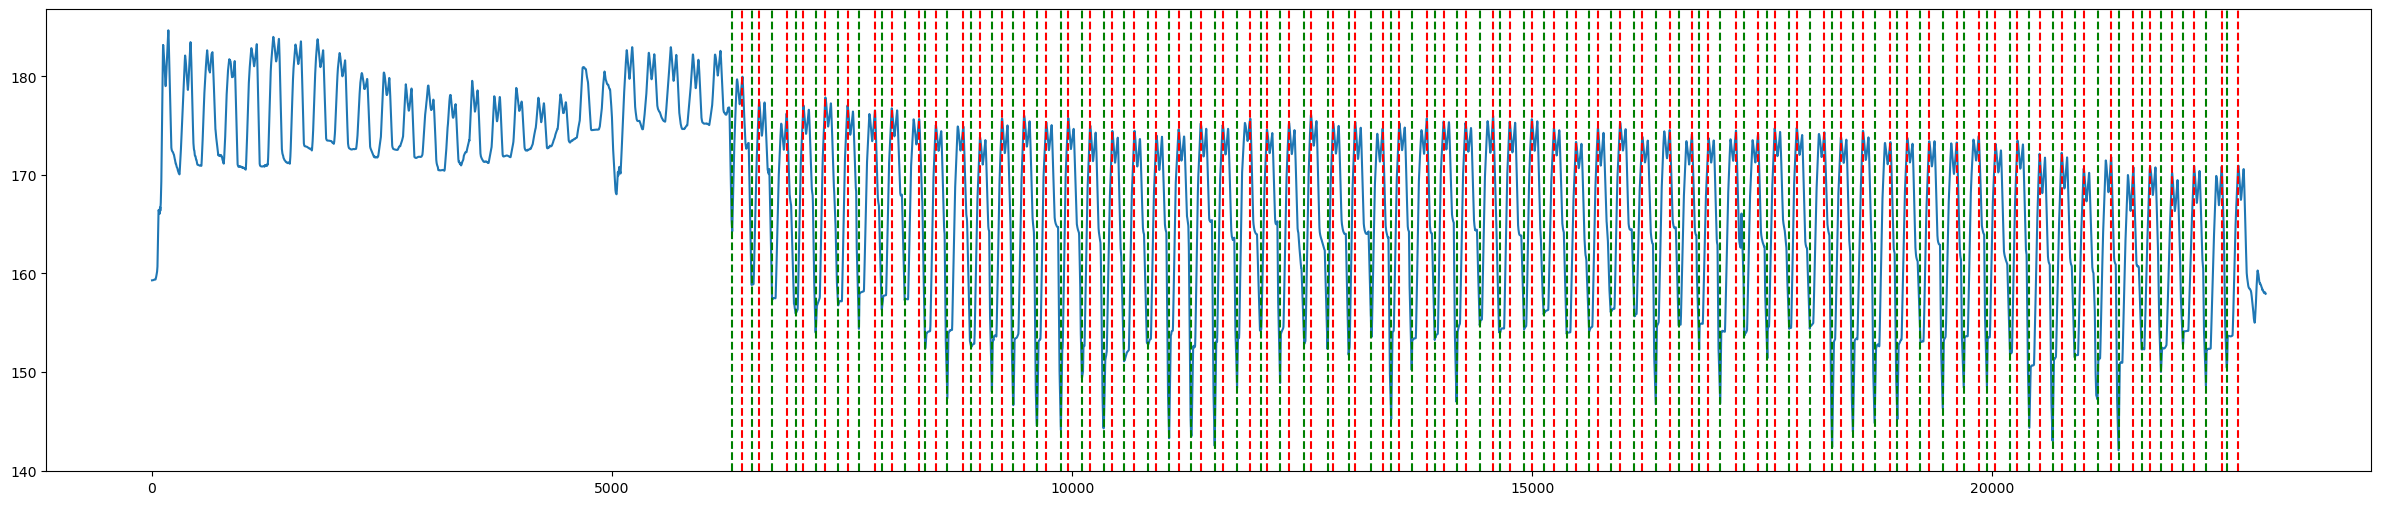

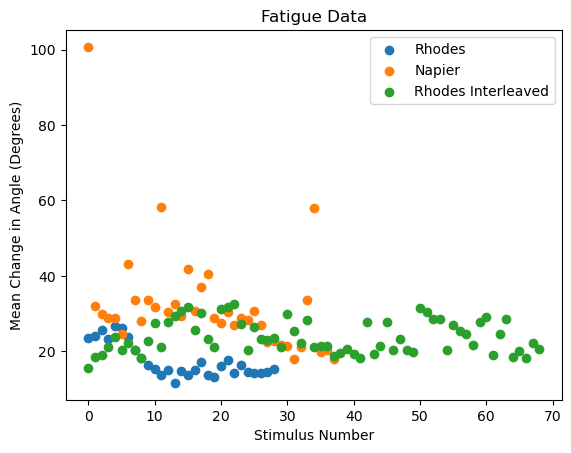

In [141]:
# rhodes.getAngleChange(2)
# napier.getAngleChange(1)
# rhodesinterleaved.getAngleChange(1)
plt.figure(figsize=(30, 6))
rhodes.testAngleChange()
plt.figure(figsize=(30, 6))
napier.testAngleChange()
plt.figure(figsize=(30, 6))
rhodesinterleaved.testAngleChange()
plt.figure()
plt.scatter(np.arange(len(rhodes.angleChanges)), rhodes.angleChanges, label='Rhodes')
plt.scatter(np.arange(len(napier.angleChanges)), napier.angleChanges, label='Napier')
plt.scatter(np.arange(len(rhodesinterleaved.angleChanges)), rhodesinterleaved.angleChanges, label='Rhodes Interleaved')
plt.xlabel("Stimulus Number")
plt.ylabel("Mean Change in Angle (Degrees)")
plt.title(f'Fatigue Data')
plt.legend()
